# Import libraries

In [1]:
# !pip install tensorflow==2.8
# !pip install tensorflowjs
# !pip install numpy==1.21
# !pip install protobuf==3.20.*
# !pip install scikit-learn
# !pip install matplotlib
# !pip install seaborn

In [2]:
import pathlib
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, recall_score, precision_score, accuracy_score
from tensorflow.keras.utils import set_random_seed
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import shutil

In [3]:
import tensorflowjs as tfjs

# Setting a seed
Setting a seed so we can guarantee the same results no matter how many times we run the script

In [4]:
seed = 1605
np.random.seed(seed)
set_random_seed(seed)

# Setting the image directory

In [5]:
train_path = pathlib.Path("./data/train")
val_path = pathlib.Path('./data/val')

# Run next cell to copy all test images into folder named test_together
## DISCLAIMER
The folder test_together needs to exist beforehand

In [6]:
# test_path = pathlib.Path('./data/test')
# test_data = list(test_path.glob('*'))

# for i in range (0, len(test_data)):
#     print('subpath[i].name', test_data[i].name, 'len', len(os.listdir(test_data[i])))
#     for filename in os.listdir(test_data[i]):
#         print(filename)
#         my_dest = test_data[i].name + '_' + filename
#         my_source = './data/test/'+ test_data[i].name + '/' + filename
#         my_dest = './data/test_together/' + my_dest
#         # rename() function will
#         # rename all the files
#         shutil.copy(my_source, my_dest)

In [7]:
subpath = list(train_path.glob('*'))
species = []
boxplot_data = []

for i in range (0, len(subpath)):
    species.append(subpath[i].name)
    boxplot_data.append([subpath[i].name, len(os.listdir(subpath[i]))])

species.sort()

In [8]:
no_of_files = pd.DataFrame(columns=['Species', 'No of files'], data=boxplot_data)
count_more_than_1000 = 0
list_of_species_to_keep = []

for index, row in no_of_files.iterrows():
    if row['No of files'] >= 1000:
        count_more_than_1000 += 1
        list_of_species_to_keep.append(row['Species'])
        
list_of_species_to_keep        
count_more_than_1000

65

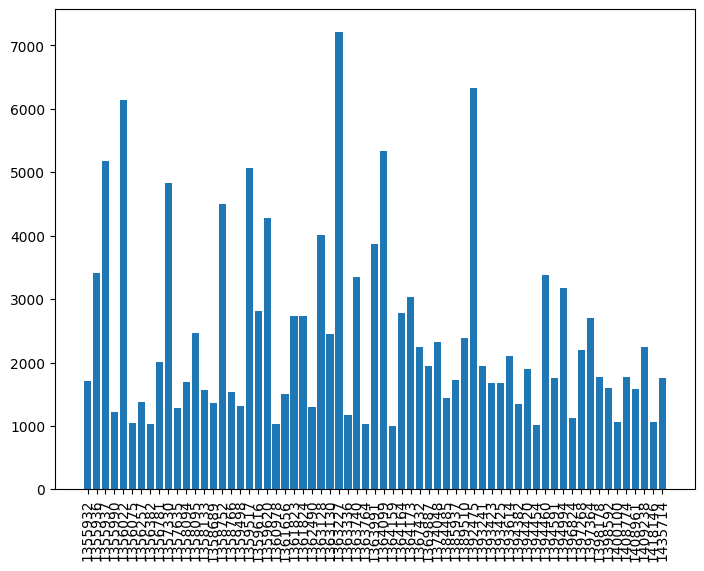

In [9]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plot_species = no_of_files['Species']
plot_numbers = no_of_files['No of files']
ax.bar(plot_species,plot_numbers)
plt.xticks(rotation = 90)
plt.show()

# Setting image height and width

In [10]:
image_size = (150, 150) # (height, width)

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed=1337,
    image_size=image_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    seed=1337,
    image_size=image_size
)

Found 157722 files belonging to 65 classes.
Found 19759 files belonging to 65 classes.


# Setting the model

In [12]:
model = Sequential()

# adding layers
model.add(Conv2D(128, (3, 3), input_shape=(image_size[0], image_size[1], 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
model.add(Conv2D(32, (1, 1), input_shape=(image_size[0], image_size[1], 3), activation='relu'))
model.add(Conv2D(96, (1, 1), input_shape=(image_size[0], image_size[1], 3), activation='relu', padding='valid'))
model.add(Conv2D(96, (3, 3), input_shape=(image_size[0], image_size[1], 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
model.add(Conv2D(64, (1, 1), input_shape=(image_size[0], image_size[1], 3), activation='relu'))
model.add(Conv2D(192, (1, 1), input_shape=(image_size[0], image_size[1], 3), activation='relu', padding='valid'))
model.add(Conv2D(192, (3, 3), input_shape=(image_size[0], image_size[1], 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(Dense(len(species), activation='softmax'))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 32)        4128      
                                                                 
 conv2d_2 (Conv2D)           (None, 74, 74, 96)        3168      
                                                                 
 conv2d_3 (Conv2D)           (None, 74, 74, 96)        83040     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 96)       0         
 2D)                                                    

# Setting epochs and fitting the model

In [14]:
epochs=1

In [15]:
result = model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=300) #batch_size=1

4929/4929 [==============================] - 524s 105ms/step - loss: 2.9730 - accuracy: 0.2571 - val_loss: 2.4387 - val_accuracy: 0.3796


# Graph of loss change and accuracy change on train and val datasets

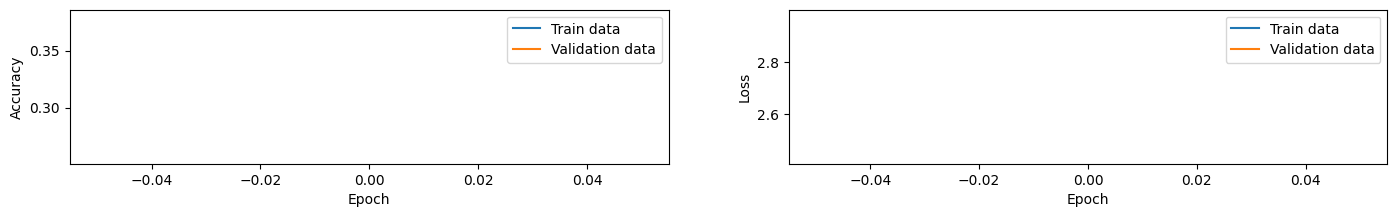

In [16]:
history = result

acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
loss_train = history.history['loss']
loss_val = history.history['val_loss']

plt.figure(figsize=(17, 2))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc_train, label='Train data')
plt.plot(range(epochs), acc_val, label='Validation data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss_train, label='Train data')
plt.plot(range(epochs), loss_val, label='Validation data')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [17]:
scores = model.evaluate(val_ds, verbose=0)
print('Val loss:', scores[0])
print('Val accuracy:', scores[1])

Val loss: 2.438657522201538
Val accuracy: 0.37957385182380676


In [18]:
def get_plant_species(filename: str):
    spl = filename.split('_')
    return spl[0]

In [19]:
test_folder = pathlib.Path('./data/test_together')
test_images = list(test_folder.glob('*.jp*'))

y_pred = []
y_true = []

In [20]:
for file in test_images:
    print(file.name)
    img = keras.preprocessing.image.load_img('./data/test_together/' + file.name, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Saving the predictions
    pred = model.predict(img_array)
    
    # Finding the correct prediction
    y_pred.append(species[np.argmax(tf.nn.softmax(pred[0]))])
    
    y_true.append(get_plant_species(file.name))

1355932_01ff8cde7f703baba950cd9475c749acc497263c.jpg
1355932_0b9c0868b55b317d19413a5913e13f24f565cbf9.jpg
1355932_0b9c8b7c27b188f5ade14c4b0d30469ecb77a079.jpg
1355932_0bb4c4e4a9613f9f8789e9ed9df702e0021be0af.jpg
1355932_0d58803f40a5986c4067e969b146c8ec3cb6cdff.jpg
1355932_0f841a81e9a5e1caa4951230e735316b6bc5c635.jpg
1355932_1a3e3e5481a65e02456bae3879b81ea63a038286.jpg
1355932_1aead2de928450295856c22227f36fc5d6ba5650.jpg
1355932_1b8a8b4b147870e9b2b77f778cd1e030657e896b.jpg
1355932_1cb45191633e59b7b0c83900b5edc8e3405ae8be.jpg
1355932_1dd5afd29a77de8a793f45c6fc1dfd13f3b919af.jpg
1355932_1f69ab8dcc622f5aca523999f3717430bb716a7e.jpg
1355932_1ff4f6c87032db705a0b306c41f6b4da5564b69d.jpg
1355932_2a535594dcf9d39e48dd5805e79b2541fbd8c068.jpg
1355932_2d5142256b1e670e7798335783a4a023fa73e610.jpg
1355932_2e0cc6e2cf3defdefa8c9e808a0d9f12e2913a97.jpg
1355932_2e1e3fd393f76908de026bcc6088b1ad6eb3686f.jpg
1355932_3a4e8278518cc03e56ada727bc916bcaf999e719.jpg
1355932_3acfad33c821a8b398be3f9bffe23bca390601

1356382_6af65f0dcd6babfaf51a38e25c076146f35427d9.jpg
1356382_6b1674310b6d408d1bf4fb244f40c933cf493bc9.jpg
1356382_7f46b5f82bba9e70a52b1f0f29ed00e19805d091.jpg
1356382_8da36bef49dc702ddab785566b5332dc84d149a6.jpg
1356382_8e2a84d64165267b50cd05aa8e49c8a3b47bb620.jpg
1356781_02c1a550227ebb6fb420d4d1f1592a38564405be.jpg
1356781_03a246e041d5342dcb5d87ec3497e950fb7fcc5f.jpg
1356781_0a85086d2218d469070d095500671dea10ccf16d.jpg
1356781_0ae138e624538fbe6c9282552ee598046c646c66.jpg
1356781_0b0347c7feea29be9e81126b50d106eecf0a0a63.jpg
1356781_0b2d07b4841b6e80d54c6c2efe47806a624788af.jpg
1356781_0bebb1e96ec29830dc42d38abf0c7d7c0973547a.jpg
1356781_0c2c34cf7c985bd871ef6d29519dc59bfe50c809.jpg
1356781_0c2dbc53402368f3c431f623aaf17c031a03d229.jpg
1356781_0c854735f29119ba3102df5edb297843b3981b31.jpg
1356781_0fb18a9e596cda022ef921dbdcf78da794cf62b7.jpg
1356781_1a2515fef5fc856e98a8a3c9c7ea12373aa4802d.jpg
1356781_1a606c6fffd22c4b21445e3f40ea77575a9209ed.jpg
1356781_1bafc06479555519ee918eea32d70fc2dcdbda

1358752_0ee1f361cf7e9254ae9e0d0f37c4bceeb83dfe63.jpg
1358752_0f5ba7f17fa0285418135e5c7a565dad2251b528.jpg
1358752_0fdac5de83e267f231f41716b94eaabdade298b9.jpg
1358752_1a6149f6af8a8da1e3eccf258cc7b35699971f70.jpg
1358752_1a80c6f22ed58e063c852d9c225be063769e25e6.jpg
1358752_1a9f2a1fafe492e53765fdc2c44f25667ec46a4b.jpg
1358752_1aa43745f1fd01fc2b544c7febd90e71c51a082e.jpg
1358766_01d1b6346e6d1c8d3aeb87796030206d16dd7203.jpg
1358766_0b6f5325d84889ca58904ca2390f9f1b5e770c99.jpg
1358766_0cac59d9145517493c43829d576cb9619322adeb.jpg
1358766_0ccb1019bfcfa742bca5537a3545d0d21ad644af.jpg
1358766_0d32422a4aab9264bfe28d6c9ff208f76fedc4ad.jpg
1358766_0da44c253f989ab65af13878c27ca5f81e11f939.jpg
1358766_0e0fc363b5a37d2df50ba3281b52bbe9afbbc7eb.jpg
1358766_0e6501cf3a14849b516a578569f87c84caf3ace8.jpg
1358766_0ea6bb957e1a56e19ba23d5c306904c299d87a08.jpg
1358766_0fc4a4ae32264e03197f5644e52e8cdf8efada15.jpg
1358766_1c794ddffeecd467f3b141dd31ce291bb87d0ec6.jpg
1358766_1da57e2f0a8af3303a3670eebdcf1cdad300de

1361823_0f0d084aec44b91c70c09f2e48916ddb2cba76b0.jpg
1361823_0fd3c7ee99b38646c1130e0af840afa48b178744.jpg
1361823_1d2735005cb19fdbeda842b8236f78387495455d.jpg
1361823_1e6765c44b60d484d184cf4e28e78ca97f2443b8.jpg
1361823_1f59f772630c5dd8321261b14687580b755c2166.jpg
1361823_2c91e1be6b641df4e0e3ee72517b804aca8a4291.jpg
1361823_2c9c016c0f1804d685eccca6d1958977fc5a499b.jpg
1361823_2cb01a6db03740b41ed004f2a725e7b46943e96f.jpg
1361823_2d1128de4cff86025ef832ae4577ce00fb8a046c.jpg
1361823_2d91849f3ec1f750a28b2cba18a300aa4d677b78.jpg
1361823_2dd22f9d39eb2468e36673c66d43a110d3947f69.jpg
1361823_2e0edb1f03a3221517efff9458cc2c11ec06b43c.jpg
1361824_00ced73f1adce44a3956debcfacaf359bc72a1e0.jpg
1361824_00dbc4819d56e7cbc02be87c8d411590018c84c1.jpg
1361824_00eb2ffb5c3fdbe94df2ff0077f23a5bc2188399.jpg
1361824_01c87caebbcc8f5763f1d27d5ff9b9e369f3c2af.jpg
1361824_01e27404d16b86ac3b446be96101947a1146aad1.jpg
1361824_0a2999c0fbc01c25e7815270d390145f5d87efc7.jpg
1361824_0bcb2ba58cdb7b9ec74d5e1a5e7ca60df5cd05

1363764_1c1f36b0af1d96f85839c4418db7e9f38d987cd0.jpg
1363764_1d16243c59cced47cd91990b2d1b83f5533914be.jpg
1363764_1d362c1765f0ff0b81bfd5e5eacc463b18d9fd95.jpg
1363764_1f0926127829593cf40c68215552ec93995de2a9.jpg
1363764_1f28ed8fbd834d01324c488cf8dae19f545faae2.jpg
1363764_2ab70ae2b4bbf54a4e01cb9404880ec45f6dc5ed.jpg
1363764_2d5ca29533d7bd570b27034ed5fd412ee46848d4.jpg
1363764_2d7d30c75692848f603fc86d1f171bd35503d559.jpg
1363764_2dfc7681fed5761114d067ca0e613c2de1fd40e1.jpg
1363764_3a7f8704fc2d88fcce11704bc0c1d891c89c0146.jpg
1363764_3b81cf13c45c61a6ae5edcb86afa5fee6407db80.jpg
1363764_4ab2c199e6ff76a904a0f51d047910325fa68261.jpg
1363764_5d0cf6211bdf4380324817fa9b769f44158a461c.jpg
1363764_5d147ee21ba78bc8a64d2f8b03f02b75e56b27d5.jpg
1363764_5eff6d4e1e488e9b736ea408ef90209b6e2c4b0e.jpg
1363764_6cbfc5a50a94e1e9802453cfa98a0403adfb8333.jpg
1363991_01bf2772433e0fe0e4bbc7860f1219ca1b891cbc.jpg
1363991_0b6b1394f361a20a6274b52260ca47ff839ba4b9.jpg
1363991_0c4cfd966c672fe0fed0d3a96c3fb93aeb7e61

1369887_2e61734657987662b9b9a94f217b712f370f2165.jpg
1374048_01d55e0219b89b54eb7f68c14016545e0316cfad.jpg
1374048_01e3cd484d4905b4accce514dccf88f498b1f628.jpg
1374048_0a1d809587051fc5b23e0e1df72f9dac44d49e2d.jpg
1374048_0ab2a4fb55257d3f1a2070b22cc33f5f5baea0e2.jpg
1374048_0ad2bbcb9e5d411a94fe0eb4bfb68f357e19d386.jpg
1374048_0ad2e7aeb7ae15104da51999d1759fbde980a0f7.jpg
1374048_0afc44c37e2ccb9c0806fd98fb4fbfb9f8cdc671.jpg
1374048_0bb21f84d85475b17712759722da03a669ef5b41.jpg
1374048_0be56379e9751a9db6563d5c46ff566e164912ea.jpg
1374048_0cd8fd1e177e7fcfc4f8b0fedb54ad7ae62dd323.jpg
1374048_0e89bea904178a8cb938f31984e32b7533ac0675.jpg
1374048_0eeb39cd1639342131a6ad2106914f11c748a82f.jpg
1374048_1a5a1eeb5d0da15637efea86ebfd09f3e5559034.jpg
1374048_1c22d18b68026324796784225ca94239d397902c.jpg
1374048_1cd1846e5f852f3caa3c05538624686fa9f384b7.jpg
1374048_1d5f9377df2dd51f06dcaa9b197c0d91099138a4.jpg
1374048_1dcc78dc048090545a43b00b924f927745f61258.jpg
1374048_2cbf897ba17157582e4f81984b78e8da3d0716

1393425_4aed54007ff92aea813cc52991975e418ef04242.jpg
1393425_4b69137f0fd1f267869921ba9a068f4820709234.jpg
1393425_4c7c83e24474aa48bc33f961ed2ada712c89c010.jpg
1393425_4ef57b36a85b539ce56d9f6d360a02ec417d119c.jpg
1393425_4f5f344e0a69ed4beffe988ddb88103ff1e9202b.jpg
1393425_5a8417aa366205ebc27da69389293c33c6405838.jpg
1393614_00a318fa3132a7cd28f410d157432f99ce6b0f06.jpg
1393614_02daf0cce6492cc3819114842a5784dda125455f.jpg
1393614_0c1dbfd8b0f3f64423b46172b3ec4861bc66ef20.jpg
1393614_0e3d5e05d5f3a4e0117c26d9f90728a52312f6d8.jpg
1393614_0e58554fcba5a3abf6642af9d45a8e50d9b605c0.jpg
1393614_0ec795eda9b2ffb5f83924e3e2d3ebbd3b067444.jpg
1393614_0ee636cbf61802285de4f9fdb417693f0c77a8dd.jpg
1393614_0ffb204eff6dfa9d5ecbea735fa3724b7d278f40.jpg
1393614_1a3ef20a4ec7165b6c308358d048174546440f4c.jpg
1393614_1a892e82d4ca9f5f1b1af8f7bb0604c565ddc1ce.jpg
1393614_1b4163e535a8efaeb2a809ad566a0c3c9dabe2e5.jpg
1393614_1c054b4c87e8960d5d4c3828492597a66411a2c9.jpg
1393614_1d1e8bbd36792f98b649f9b188e7b573806859

1396824_2c89fd02ba476a9cb9be362b131e46b477eb84ec.jpg
1396824_2c9cdf5b967d924a0fe9a9119f061ae39177cbdc.jpg
1396824_2cb11e9c869f600f2563e25c3bc65c282d30fe0c.jpg
1396824_3ad0dce00d83a589ccf9a20619e7c01f38a4d374.jpg
1396824_3c27f8aead8377c135465989d80ee90fa9c967cc.jpg
1396824_3dae1528966f6156668e477a864f68408a6356fd.jpg
1396824_3f32c423312d94182f1dc55cf9908da631b345b4.jpg
1396824_3facc4d4e9fb00eb6e4a0050883d957b4d8e13cb.jpg
1396824_4c74d251144aff7ff086feda8632efac039ff961.jpg
1397268_0abb36b0eda074d9fcbdb9903ca6f6b9759ec974.jpg
1397268_0bce5e8168410763336f28b12e4712e2ff9e462e.jpg
1397268_0c328c818d64d69c97b2b951176358fb52b2a2e8.jpg
1397268_0df4c576445cae540dda8eb12db2119bf6625c2e.jpg
1397268_0f315c670d073e4dcb5eb3115d22709cda7fa8d2.jpg
1397268_0f53de7f8de4d5fdf1615f18fc53eae47bfd0c56.jpg
1397268_0f5e141e5cac0247773f0044cb428e57219a1c90.jpg
1397268_1a4187d7040ee6b4aa78e6fc61889e3c4898eb58.jpg
1397268_1a90dba321a2f4fc6270d93d1835153001289253.jpg
1397268_1b182cbb022641dd17ec88d9b2b9530309c2ff

1409238_0ede2752bc593d06bf33f3251614bf906572e1fc.jpg
1409238_1a9eaaadd1eb1ea023f2902c1c3b8a724331162e.jpg
1409238_1dfc7051f1d2996d89fd1d6f81d6c5042b48e165.jpg
1409238_1f452ea1a398b541b74ca14ef0c80dc4884588a7.jpg
1409238_1ff2a44f8ab00a50ef6c06e0e57b3965f2104713.jpg
1409238_2af1c54f4cca2def7ef78572425bf21fa8f8a31f.jpg
1409238_2bc3b20abb59fe13d41a864853570de2c54d39a2.jpg
1409238_2c3cd7eefaaee81019378916357ed41fc345a2c0.jpg
1409238_2d729c9a97bbddda336ea90df4cb0d043b45951c.jpg
1409238_2e59f3663cf18e331d1e3436c1970aa8e9b3fb79.jpg
1409238_2f10f7b442f86fd180d00d07a44447b78c7ea8f4.jpg
1418146_0a488b6aebc73c72442a7a0a0c43e7b22d05fa04.jpg
1418146_0f2ddb900efda11d5c9d265019ec418a52904630.jpg
1418146_0f30c4a66524554257ff0a961881d9f407cfe598.jpg
1418146_1c5c2d001d0f003c8107380587f9ef85852c7256.jpg
1418146_1cb05908e1209af42f66d8d36a38d3a113fc1c4e.jpg
1418146_2a98b719eeea18d2c7c93f5c0b0fc5179a607f23.jpg
1418146_2c2831f1eb67ed36a79da82ffe6c18da7c61e522.jpg
1418146_3b3e4420d617483b314186126895b071ab34f9

# Confusion matrix

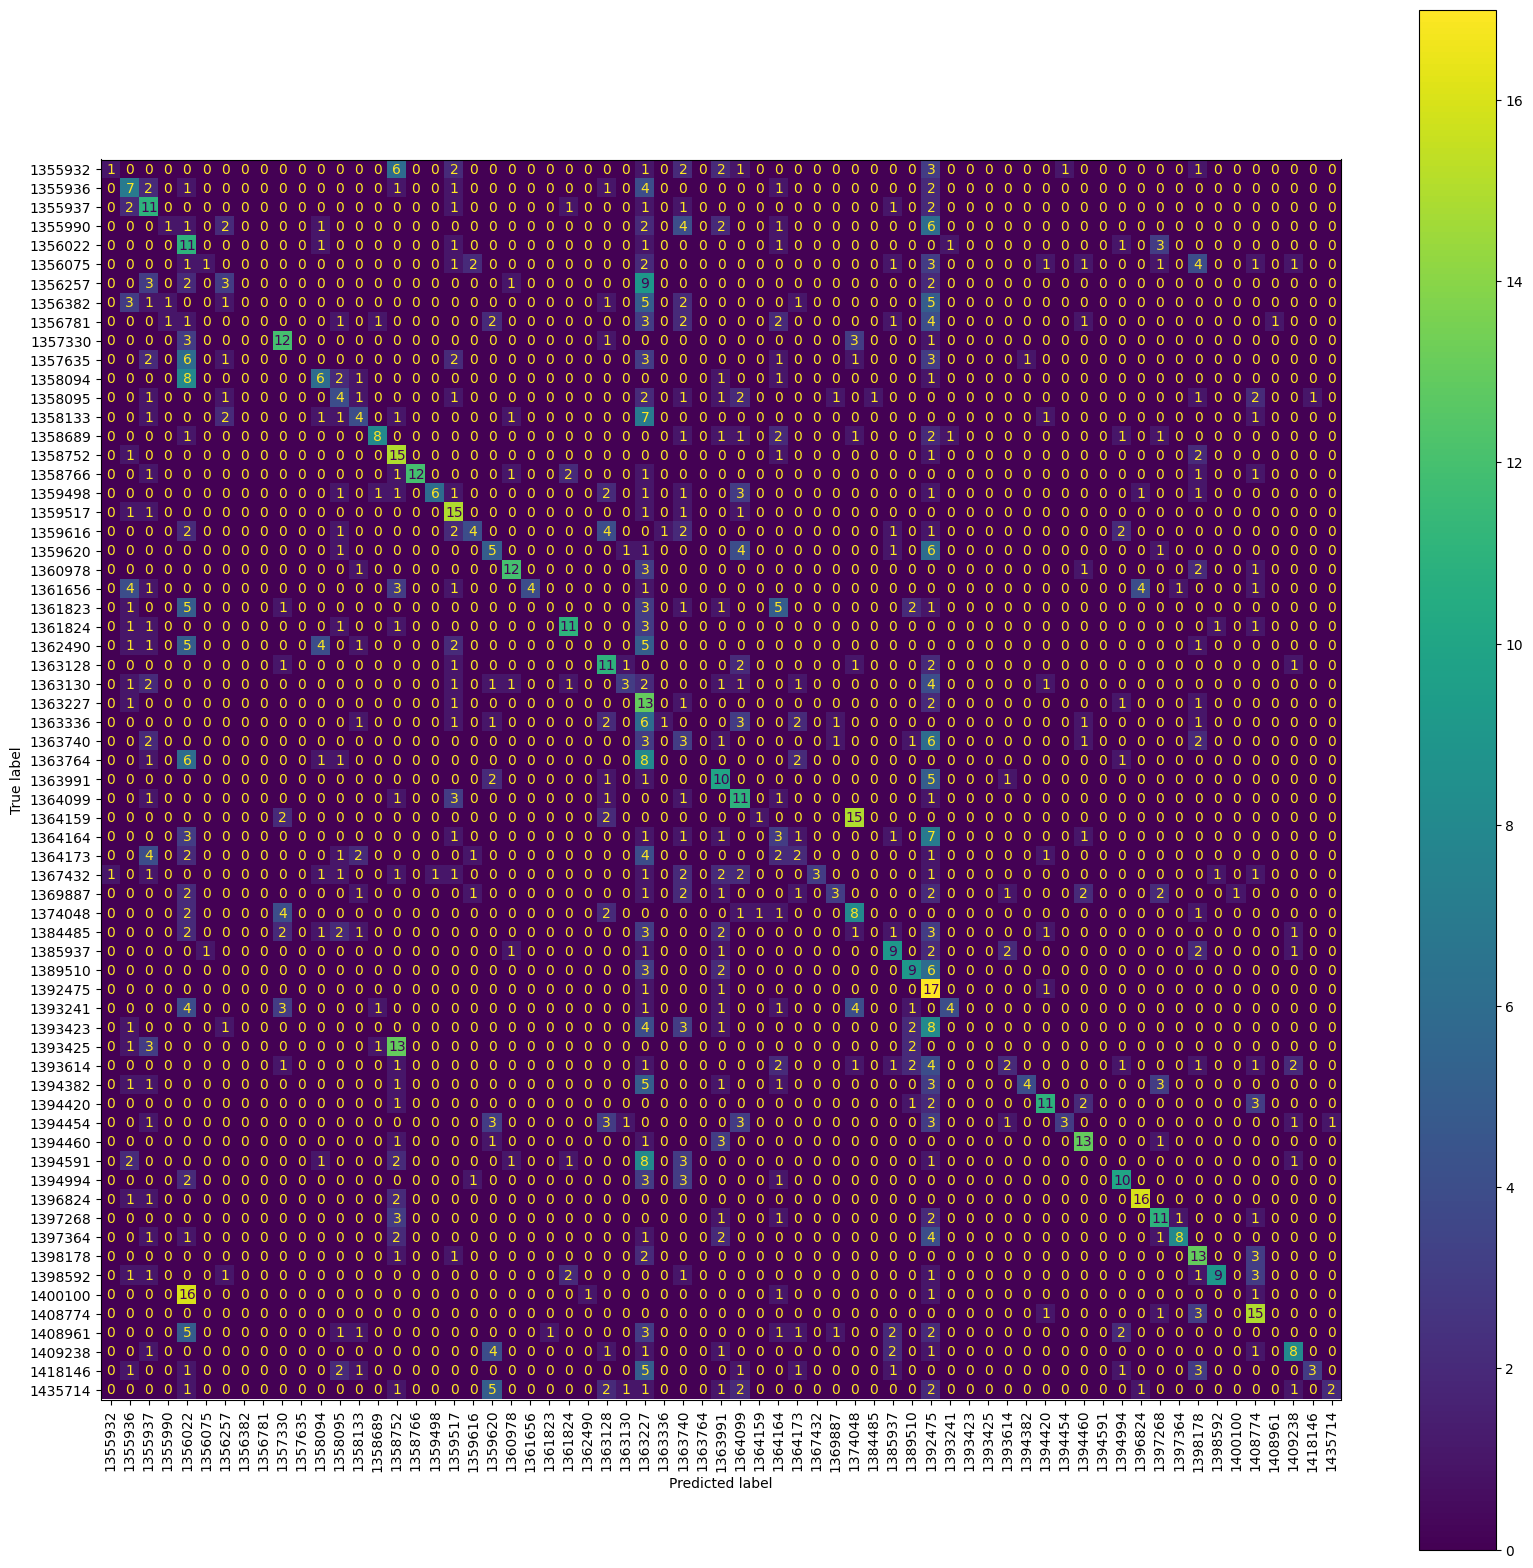

In [21]:
matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
matrix_display = ConfusionMatrixDisplay(matrix, display_labels=species)
fig, ax = plt.subplots(figsize=(20,20))
matrix_display.plot(ax=ax)
plt.xticks(rotation=90)
plt.show()

In [22]:
test_accuracy = accuracy_score(y_true, y_pred)
print('Test accuracy: ', test_accuracy)
test_precision = precision_score(y_true, y_pred, average='weighted')
print('Test precision: ', test_precision)
test_recall = recall_score(y_true, y_pred, average='weighted')
print('Test recall: ', test_recall)
test_f1 = f1_score(y_true, y_pred, average='weighted')
print('Test f1 score: ', test_f1)

Test accuracy:  0.30153846153846153
Test precision:  0.37640398605988207
Test recall:  0.30153846153846153
Test f1 score:  0.27587292484779985


C:\Users\Zala\anaconda3\envs\tf_GPU\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Saving the model
Firstly we save it in the default format and then the HDF5 format.

In [23]:
model_version = '0.1.6'

In [24]:
model.save('./exported_models/v'+model_version+'/botaniai_model_'+model_version+'.keras')

In [25]:
model.save('./exported_models/firebase_model')

INFO:tensorflow:Assets written to: ./exported_models/firebase_model\assets


In [26]:
model.save('./exported_models/v'+model_version+'/botaniai_model_'+model_version+'.h5', save_format='h5')

In [27]:
model_json = model.to_json()
with open('./exported_models/v'+model_version+'/botaniai_model_'+model_version+'.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('./exported_models/v'+model_version+'/botaniai_model_weights_'+model_version+'.h5')
print("Saved model to disk")

Saved model to disk


# Convert model to tensorflow.js format

In [28]:
tfjs.converters.save_keras_model(model, './tensorflowjs/v'+model_version+'/')